In [26]:
import pandas as pd
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import log_loss, accuracy_score, f1_score, brier_score_loss

In [2]:
folder = 'C:\\Users\\Pascal\\Documents\\GitHub\\'

In [3]:
df = pd.read_csv(folder + 'data_100.csv')

In [4]:
df.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,9252892,976653,12858,10,1,192424,8,2,11,14.000000,Pecan Pie Fruit & Nut Food Bar,3,19,snacks
1,31936762,3368597,31288,6,1,192424,7,2,14,11.000000,Lowfat Key Lime Yogurt,120,16,dairy eggs
2,33336496,2226284,10768,14,1,192424,14,6,13,20.000000,Organic Raspberry Lowfat Yogurt,120,16,dairy eggs
3,31936766,3368597,2732,10,0,192424,7,2,14,11.000000,Gluten Free Pretzel Sticks,107,19,snacks
4,10580466,1116941,11068,9,0,192424,1,6,8,11.364153,Medium Cheddar Cheese Block,21,16,dairy eggs


In [5]:
df.drop(['Unnamed: 0', 'product_id', 'order_id', 'user_id', 'department', 'product_name'], axis=1,inplace = True)

In [6]:
print(df.isnull().sum().sum())

0


In [7]:
CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order"]

In [8]:
#One-hot encoding categorical columns
df = pd.get_dummies(df, columns=[x for x in CATEGORICAL_COLUMNS])

In [9]:
#Normalising the feature columns
df[CONTINUOUS_COLUMNS] = preprocessing.MinMaxScaler().fit_transform(df[CONTINUOUS_COLUMNS].values)

In [10]:
#df.drop(['product_name','department','product_id','user_id'], axis=1, inplace=True)

In [11]:
y = df.reordered.values

In [12]:
df.drop(['reordered'], axis=1, inplace = True)

In [13]:
X = scale(df)
X = X.astype(floatX)
Y = y.astype(floatX)

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=y)

In [15]:
df.head()

,add_to_cart_order,order_number,days_since_prior_order,order_dow_0,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,...,department_id_12,department_id_13,department_id_14,department_id_15,department_id_16,department_id_17,department_id_18,department_id_19,department_id_20,department_id_21
0,0.134328,0.070707,0.466667,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.074627,0.060606,0.366667,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.194030,0.131313,0.666667,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0.134328,0.060606,0.366667,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.119403,0.000000,0.378805,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [16]:
X_train = np.array(X_train, dtype = theano.config.floatX)
y_train = np.array(y_train, dtype = theano.config.floatX)
X_test = np.array(X_test, dtype = theano.config.floatX)
y_test = np.array(y_test, dtype = theano.config.floatX)

In [17]:
def construct_nn(ann_input, ann_output):
    n_hidden = 100

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)
neural_network = construct_nn(ann_input, ann_output)

In [18]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [19]:
%%time

with neural_network:
    #inference = pm.ADVI()
    approx = pm.fit(n=1000, method='advi')

Average Loss = 28,837: 100%|██████████| 1000/1000 [1:35:36<00:00,  5.59s/it]
Finished [100%]: Average Loss = 28,832


Wall time: 1h 35min 38s


In [20]:
import pickle

trace = approx.sample(draws=1000)

with open(folder + 'trace.p', 'wb') as f:
    pickle.dump(trace, f)
    


In [ ]:
with open('trace.p', 'rb') as f:
    test1 = pickle.load(f)

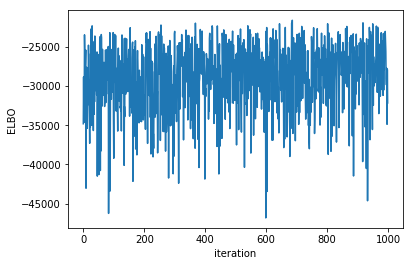

In [38]:
plt.plot(-approx.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');
plt.savefig(folder + 'advi_elbo.png', bbox_inches = 'tight')

In [28]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=200, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0)
probs = ppc

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  


In [34]:
y_test

array([1., 0., 1., ..., 0., 1., 1.])

In [36]:
print(accuracy_score(y_test, np.round(pred)), log_loss(y_test, pred), f1_score(y_test, np.round(pred)))

0.5048028817290374 0.6954283843896669 0.5774780158797916
